# Notatki do pracowni trzeciej

In [1]:
using PyPlot
include("program.jl");

In [2]:
function MaxMistakePlt(x1, x2)
    return max([ abs(x1[i]-x2[i]) for i=1:length(x1)]...)
end

function MaxMistakeFunc(cheb, f; d=1000, x0=-1.0, xend=1.0)
    data1 = ChebDraw(cheb, x0, xend, d)
    data2 = FDraw(f, x0, xend, d)
    MaxMistakePlt(data1[2], data2[2])
end

function animateG(f, fgood; N=5, iters=10, x0=[0], y0=[0], ymin=0, ymax=3, interval=1.5, eq="f")
    Y = PicardLoopG(f, x0, y0, N, iters)
    pygui(false)
    for i = 1:iters
        data = ChebDraw(Y[i], -1, 1, 1000)
        data2 = FDraw(fgood, -1, 1, 1000)
        
        IJulia.clear_output(true)
        
        fig, ax = subplots()
        
        ax[:plot](data[1], data[2], "-", color="red", label="wynik algorytmu", linewidth=1, alpha=1.0)
        ax[:plot](data2[1], data2[2], "-", color="blue", label="fgood", linewidth=1, alpha=1.0)
        
        ax[:text](1.1, ymax-(0.1)*(ymax-ymin)/3 , @sprintf("Iteracja : %d", i))
        ax[:text](1.1, ymax-0.3*(ymax-ymin)/3, @sprintf("Maksymalny błąd : %.13f", MaxMistakePlt(data[2], data2[2])))
        ax[:text](1.1, ymax-(0.5)*(ymax-ymin)/3, @sprintf("Równanie : %s", eq))
        axis([-1,1, ymin, ymax])
        display(gcf())
        clf()
        sleep(interval)
    end
end

function animate(f, fgood; N=5, iters=10, x0=0, y0=0, ymin=0, ymax=3, interval=1.5, eq="f")
    function farr(arr, x)
        y = arr[1]
        f(y, x)
    end
    animateG(farr, fgood, N=N, iters=iters, x0=[x0], y0=[y0], ymin=ymin, ymax=ymax, interval=interval, eq=eq)
end;

# Równania różniczkowe pierwszego rzędu

Na podstawie wybranych równań różniczkowych pierwszego rzędu będziemy rozważać szybkość zbieżności metody Clenshawa-Nortona w zależnośći od różnych czynników.

## Przykłady równań różniczkowych pierwszego rzędu

In [3]:
function f(y, x)
    5(y-1)/(x-2) - 10x^4/(x-2)
end
function fsol(x)
    x^5 + 1
end

fx0 =1.0
fy0 = 2.0

function g(y, x) 
    y^2
end

function gsol(x)
    1/(3/2 - x)
end

gx0=-1.0
gy0=0.4

function h(y, x) 
     2*(cos(x)^2) + y*tan(x)
end

function hsol(x)
    2sin(x)/cos(x) -2*sin(x)^3/(3*cos(x)) + 1/cos(x)
end

hx0=0.0
hy0=1.0

function p(y, x)
    -y
end

function psol(x)
    e^(-x)
end

px0=0.0
py0=1.0;


## Animacje zbieżności wybranych równań pierwszego rzędu

Poniższe animacje przedstawiają przybliżenia funkcji w kolejnych krokach iteracji Picarda.

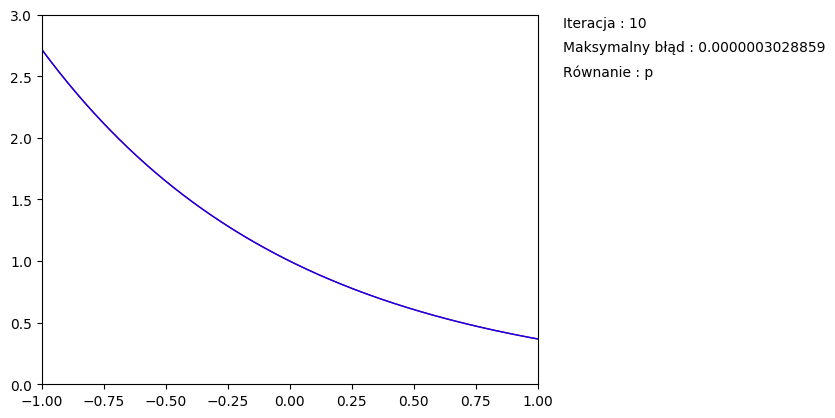

In [4]:
animate(p, psol, x0=px0, y0=py0, iters=10, N=10, interval=1.0, eq="p")

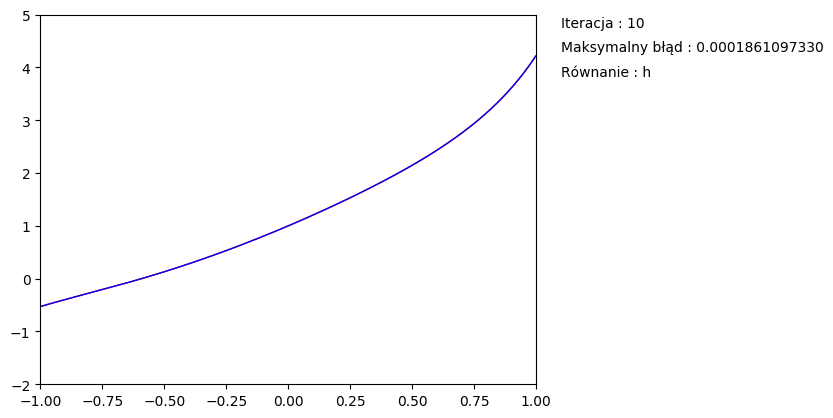

In [5]:
animate(h, hsol, x0=hx0, y0=hy0, iters=10, N=10, ymin=-2, ymax=5, interval=1.0, eq="h")

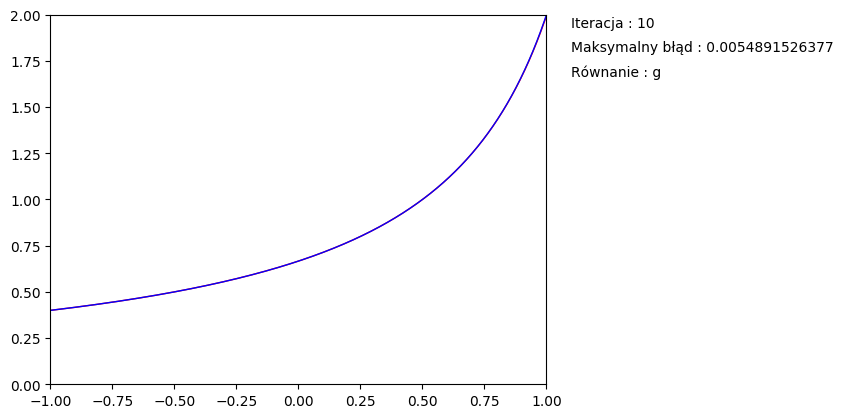

In [6]:
animate(g, gsol, N=10, iters=10, x0=gx0, y0=gy0, ymax=2, interval=0.75, eq="g")

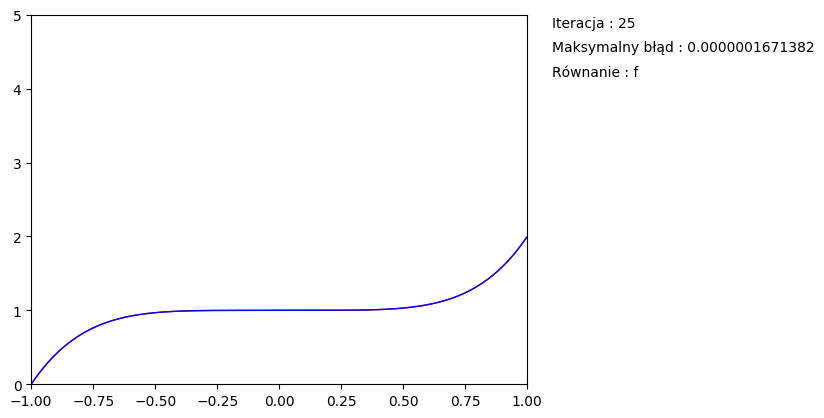

In [8]:
animate(f, fsol, N=10, iters=25, x0=fx0, y0=fy0, interval=0.5, ymax=5, eq="f")

## Dokładność w zależności od dokładności kryterium

In [9]:
function CoeffsDiff_vs_mistake(f, solution; N=10, x0=0.0, y0=0.0, ebeg=0.01, eend=1.0e-8)
    data = [[],[]]
    e = ebeg
    while e >= eend
        Y, iters = PicardLoop_conv(f, x0, y0, N, e=e)
        m = MaxMistakeFunc(Y, solution)
        push!(data[1], e)
        push!(data[2], m)
        e /= 3.0
    end
    data
end;

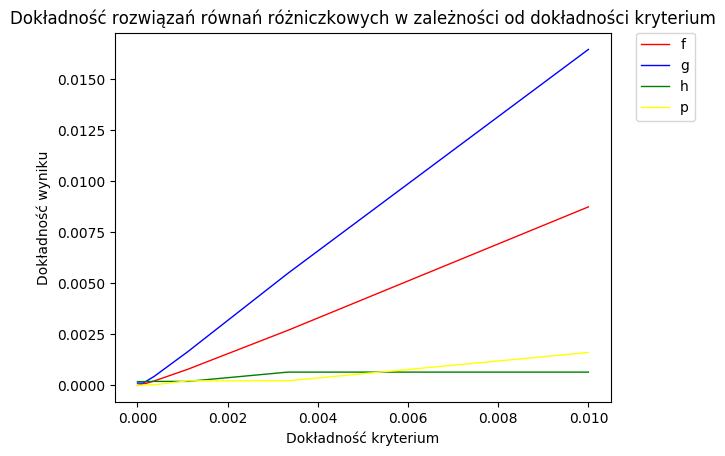

In [10]:
data1 = CoeffsDiff_vs_mistake(f, fsol, N=10, x0=fx0, y0=fy0)
data2 = CoeffsDiff_vs_mistake(g, gsol, N=10, x0=gx0, y0=gy0)
data3 = CoeffsDiff_vs_mistake(h, hsol, N=10, x0=hx0, y0=hy0)
data4 = CoeffsDiff_vs_mistake(p, psol, N=10, x0=px0, y0=py0)
fig, ax = subplots()
ax[:plot](data1[1], data1[2], "-", color="red", label="f", linewidth=1, alpha=1.0)
ax[:plot](data2[1], data2[2], "-", color="blue", label="g", linewidth=1, alpha=1.0)
ax[:plot](data3[1], data3[2], "-", color="green", label="h", linewidth=1, alpha=1.0)
ax[:plot](data4[1], data4[2], "-", color="yellow", label="p", linewidth=1, alpha=1.0)

ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
xlabel("Dokładność kryterium")
ylabel("Dokładność wyniku")
title("Dokładność rozwiązań równań różniczkowych w zależności od dokładności kryterium")
show()

## Liczba dokładnych cyfr w zależności od liczby iteracji, stałe N 

In [11]:
function iters_vs_mistake(f, solution; N=10, x0=0.0, y0=0.0, Rbeg=10, Rend=40)
    data = [[],[]]
    for R=Rbeg:Rend
        Y = PicardLoop(f, x0, y0, N, R)
        m = MaxMistakeFunc(Y[end], solution)
        push!(data[1], R)
        push!(data[2], -log(10, m))
    end
    data
end;

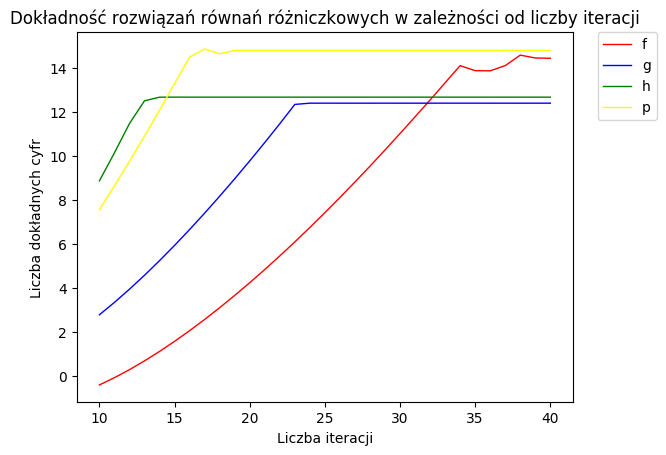

In [12]:
data1 = iters_vs_mistake(f, fsol, N=30, x0=fx0, y0=fy0)
data2 = iters_vs_mistake(g, gsol, N=30, x0=gx0, y0=gy0)
data3 = iters_vs_mistake(h, hsol, N=30, x0=hx0, y0=hy0)
data4 = iters_vs_mistake(p, psol, N=30, x0=px0, y0=py0)



fig, ax = subplots()
ax[:plot](data1[1], data1[2], "-", color="red", label="f",linewidth=1, alpha=1.0)
ax[:plot](data2[1], data2[2], "-", color="blue", label="g", linewidth=1, alpha=1.0)
ax[:plot](data3[1], data3[2], "-", color="green", label="h", linewidth=1, alpha=1.0)
ax[:plot](data4[1], data4[2], "-", color="yellow", label="p", linewidth=1, alpha=1.0)


title("Dokładność rozwiązań równań różniczkowych w zależności od liczby iteracji")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
xlabel("Liczba iteracji")
ylabel("Liczba dokładnych cyfr")
show()

## Dokładność w zależności od N, stała liczba iteracji

In [13]:
function N_vs_accuracy(f, solution; x0=0.0, y0=0.0, N0=5, Nend=30, iters=30)
    data = [[],[]]
    for N = N0:Nend
        Y = PicardLoop(f, x0, y0, N, iters)[end]
        m = MaxMistakeFunc(Y, solution)
        push!(data[1], N)
        push!(data[2], -log(10, m))
    end
    data
end;

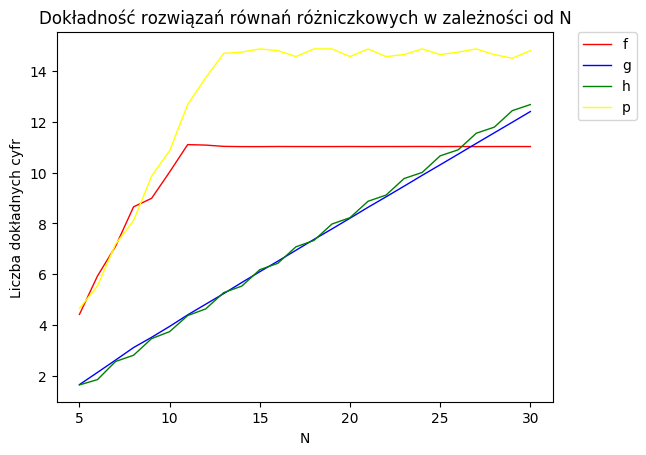

In [14]:
data1 = N_vs_accuracy(f, fsol, x0=fx0, y0=fy0)
data2 = N_vs_accuracy(g, gsol, x0=gx0, y0=gy0)
data3 = N_vs_accuracy(h, hsol, x0=hx0, y0=hy0)
data4 = N_vs_accuracy(p, psol, x0=px0, y0=py0)


fig, ax = subplots()
ax[:plot](data1[1], data1[2], "-", label="f", color="red", linewidth=1, alpha=1.0)
ax[:plot](data2[1], data2[2], "-", label="g", color="blue", linewidth=1, alpha=1.0)
ax[:plot](data3[1], data3[2], "-", label="h", color="green", linewidth=1, alpha=1.0)
ax[:plot](data4[1], data4[2], "-", label="p",color="yellow", linewidth=1, alpha=1.0)


title("Dokładność rozwiązań równań różniczkowych w zależności od N")
ax[:legend](bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
xlabel("N")
ylabel("Liczba dokładnych cyfr")
show()

## Dokładność w zależności od N i liczby iteracji

In [15]:
function NR_vs_accuracy(f, solution; x0=0.0, y0=0.0, N=5, iters=10)
    Y = PicardLoop(f, x0, y0, N, iters)[end]
    m =MaxMistakeFunc(Y, solution)
    -log(10, m)
end;

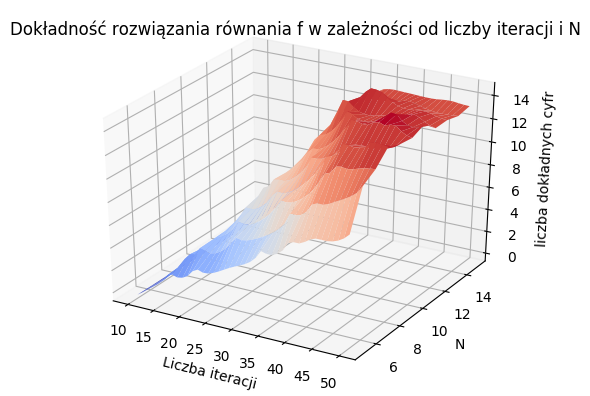

In [16]:
Nmin = 5
Nmax = 15
Rmin = 10
Rmax = 50

fig = figure()
N = [n for n=Nmin:Nmax]
R = [r for r=Rmin:Rmax]

Z = zeros(Rmax-Rmin+1, Nmax-Nmin+1)
for i=1:(Rmax-Rmin+1)
    for j=1:(Nmax-Nmin+1)
        Z[i, j] = NR_vs_accuracy(f, fsol, x0=fx0, y0=fy0, N=N[j], iters=R[i])
    end
end
surf = plot_surface(R, N, Z', rstride=1, cstride=1, linewidth=1, cmap="coolwarm")
ax = gca()

title("Dokładność rozwiązania równania f w zależności od liczby iteracji i N")
xlabel("Liczba iteracji")
ylabel("N")
zlabel("liczba dokładnych cyfr")
show()

## Równania wyższych rzędów

Na podstawie wybranych równań różniczkowych rzędu większego niż 1 sprawdzimy jakość uogólnionej metody Clenshawa-Nortona.

In [17]:
w = 15

function f(Y, x)
    y = Y[2]
    yprim = Y[1]
    -w^2*y
end

function fsol(x)
    cos(w*x) + 0.5/w*sin(w*x)
end

fx0 = [0.0, 0.0]
fy0 = [0.5, 1.0]

function g(Y, x)
    y = Y[2]
    yprim = Y[1]
    6yprim - 13y
end

function gsol(x)
    ( e^(3x) * ( cos(2x) +sin(2x) ) )
end

gx0 = [0.0, 0.0]
gy0 = [5.0, 1.0];

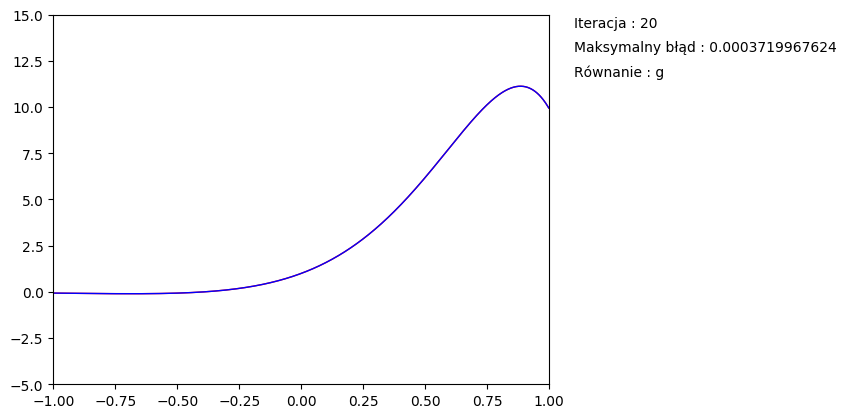

In [18]:
animateG(g, gsol, N=20, iters=20, x0=gx0, y0=gy0, ymax=15, ymin=-5, interval=0.5, eq="g")

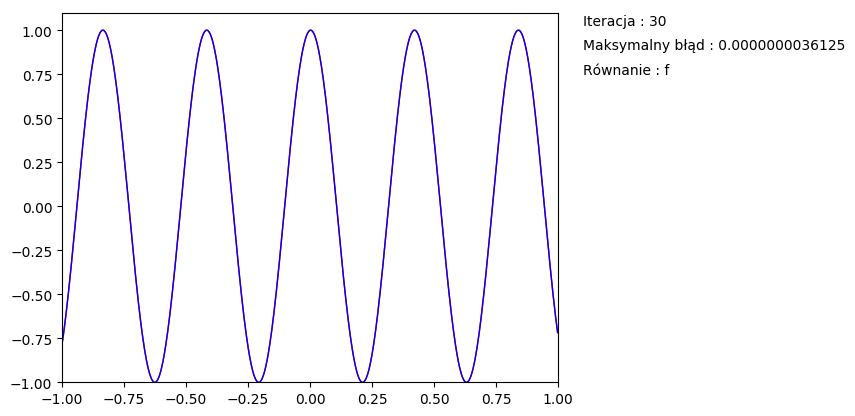

In [20]:
animateG(f, fsol, x0=fx0, y0=fy0, N=50, iters=30, ymin=-1, ymax=1.1, interval=0.2)

## Dokładność w zależności od N, 100 iteracji

Sprawdzimy dokładność w zależności od N na przykładzie równania f.

In [21]:
function N_vs_accuracyG(f, solution; x0=[0.0], y0=[0.0], N0=20, Nend=50, iters=500)
    data = [[],[]]
    for N = N0:Nend
        Y = PicardLoopG(f, x0, y0, N, iters)[end]
        m = MaxMistakeFunc(Y, solution)
        push!(data[1], N)
        push!(data[2], -log(10, m))
    end
    data
end;

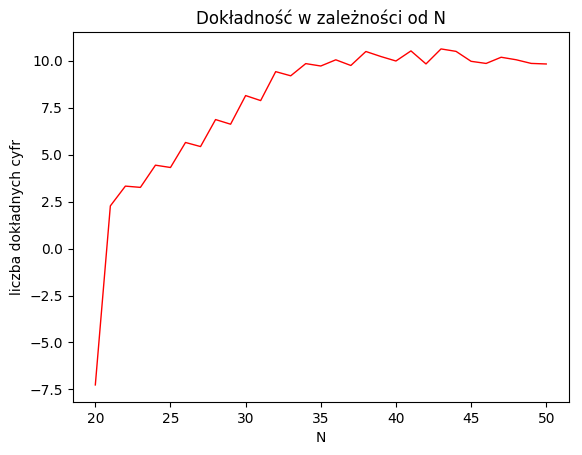

In [23]:
data = N_vs_accuracyG(f, fsol, x0=fx0, y0=fy0)
fig, ax = subplots()
ax[:plot](data[1], data[2], "-", color="red", label="f", linewidth=1, alpha=1.0)
title("Dokładność w zależności od N")
xlabel("N")
ylabel("liczba dokładnych cyfr")
show()